# Decision Making from AB Testing

Luopeiwen Yi

Most presentations of A/B testing tend to emphasize a binary approach to decision making: we run an AB test, then evaluate whether we can reject the null hypothesis of no effect. If we reject the null hypothesis of no effect, then we deploy the change; if not, we maintain the status quo. 

We have also seen some approaches that bring a little much needed nuance to this approach: in our [Trustworthy Online Controlled Experiments](https://www.amazon.com/Trustworthy-Online-Controlled-Experiments-Practical/dp/1108724264), the authors have emphasized that we should evaluate *both* 

- Can we reject the null hypothesis of no effect (to establish our results are statistically significant), and 
- Whether the estimated effect is of *practical significance*, by which they mean "does the effect size look large enough that it would be profitable to deploy."

And finally, you've probably seen cases that do the thing you should probably be doing (at least within this regime):

- Rather than evaluating statistical significance with respect to a null hypothesis of no effect, evaluate statistical significance with respect to a null hypothesis of "the effect is less than the size needed for deployment to be profitable (i.e., less than or equal to the threshold for practical significance)."

In these exercises, we will examine an approach to analyzing the results of an A/B test that is a little less black and white, and I think provides a more holistic, easy to understand, and sophisticated way of interpreting A/B test results. It comes with a couple caveats, but I'd argue none that don't apply to the approaches described above.

In short, we will:

- Analyze our data using the Frequentist statistical methods you are familiar with. Rather than just looking at p-values and rejecting or not rejecting a null hypothesis, however, we will instead interpret our results as probability distributions for what effect we might expect our experiment to have if we were to deploy it more broadly. 
- We will use this probability distribution as the basis for some Monte Carlo simulation-based analyses of the likelihood of different outcomes.
- Finally, we will touch on how this way of thinking about the result of our analyses relates to the Bayesian approach to statistical analysis.

That probably sounds pretty abstract, so to make it all more concrete, let's just start by doing our usual type of analysis of an A/B test.

## Exercise Context

In these exercises, we will be working with a tweaked version of data from [IBM Watson Analytics from a marketing A/B test conducted in the state of Washington.](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test) 

The context in which this data was generated is:

> A fast-food chain plans to add a new item to its menu. However, they are still undecided whether to run a new marketing campaign for promoting the new product. In order to determine whether the promotion will increase sales, a promotion has been deployed at a random sample of stores to promote the new item. Weekly sales of the new item are recorded for the first four weeks.

The data consists of the following variables:

- `MarketID`: unique identifier for market
- `MarketSize`: size of market area by sales
- `LocationID`: unique identifier for store location
- `AgeOfStore`: age of store in years
- `Promotion`: did the location receive the promotion (was it treated).
- `week`: one of four weeks when the promotions were run
- `SalesInThousands`: sales amount for a specific `LocationID`, `Promotion`, and `week`

(And yes, despite my general distaste for them, this is a pretty darn clean dataset. You're welcome. :) )

## Exercises

In [105]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("mode.copy_on_write", True)

### Exercise 1

Load the dataset — `WA_Marketing_Campaign.csv` from [this repository.](https://github.com/nickeubank/MIDS_Data/tree/master/fast_food_ab_test) Please use this copy (not data from the Kaggle competition from which it was drawn) as I've made a number of modifications to the data for this exercise.

In [106]:
market = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/fast_food_ab_test/WA_Marketing_Campaign.csv",
)

In [107]:
market.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,0,1,33.73
1,1,Medium,1,4,0,2,35.67
2,1,Medium,1,4,0,3,29.03
3,1,Medium,1,4,0,4,39.25
4,1,Medium,3,12,1,1,44.54


### Exercise 2

This data is currently structured as a "panel dataset", meaning that there are multiple observations for each store, one per week for four weeks. To simplify our analysis, let's sum up sales from across all four weeks for each store so we only have one observation per store. 

(In a dataset where multiple observations come from the same entity at different points in time, a proper analysis requires accounting for the fact that the different observations for each entity are not independent of one another using a method like clustering of our standard errors.) 

You should end up with 90 observations (one per `LocationID`, the identifier for individual stores).

In [108]:
# Group by 'LocationID' and sum 'SalesInThousands'
market_new = (
    market.groupby("LocationID")
    .agg(
        {
            "MarketID": "first",
            "MarketSize": "first",
            "AgeOfStore": "first",
            "Promotion": "first",
            "SalesInThousands": "sum",
        }
    )
    .reset_index()
)

market_new.head()

,LocationID,MarketID,MarketSize,AgeOfStore,Promotion,SalesInThousands
0,1,1,Medium,4,0,137.68
1,3,1,Medium,12,1,162.72
2,6,1,Medium,10,0,124.74
3,7,1,Medium,15,1,172.97
4,9,1,Medium,6,1,158.06


In [109]:
print(f"The number of observations in the new dataframe is {market_new.shape[0]}.")

The number of observations in the new dataframe is 90.


### Exercise 3

Now, using a simple linear regression in `statsmodels`, estimate the simple difference in means between stores with and without the promotion.

(We're skipping a lot of "learn about your data" and "validate your randomization by checking balance" steps — this is bad practice, but again I want us to stay focused on the analysis and interpretation for this exercise, so you can just trust it's ok.)

Based on this simple regression, would you reject the null hypothesis that the experiment had no effect using a p-value threshold of 0.05?

In [110]:
# fit the simple linear model
model = smf.ols("SalesInThousands ~ Promotion", data=market_new)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       SalesInThousands   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6386
Date:                Thu, 25 Apr 2024   Prob (F-statistic):              0.426
Time:                        12:38:29   Log-Likelihood:                -502.19
No. Observations:                  90   AIC:                             1008.
Df Residuals:                      88   BIC:                             1013.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    221.4579      9.461     23.408      0.000     202.656     240.259
Promotion     10.9382     13.687      0.799      0.426     -16.262      38.139
==============================================================================
Omnibus:                       10.731   Durbin-Watson:                   0.164
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               12.033
Skew:                           0.891   Prob(JB):                      0.00244
Kurtosis:                       2.825   Cond. No.                         2.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
# To get the coefficient for the 'Promotion' variable
promotion_coefficient = results.params["Promotion"]
print(f"Coefficient for 'Promotion' without controls: {promotion_coefficient:.4f}")

# To get the p-value for the 'Promotion' variable
promotion_p_value = results.pvalues["Promotion"]
print(f"P-value for 'Promotion' without controls: {promotion_p_value:.4f}")

Coefficient for 'Promotion' without controls: 10.9382
P-value for 'Promotion' without controls: 0.4264


> I would not reject the null hypothesis that the experiment had no effect since the p value of the promotion coefficient is 0.4264 (p value > 0.05)

### Exercise 4

We have a lot of important controls in this dataset, so add in categorical controls for `MarketID` and `log(AgeOfStore)`.

Now would you feel comfortable rejecting the null hypothesis of no effect at a p-value threshold of 0.05?

In [112]:
# Adding log of AgeOfStore
market_new["log_AgeOfStore"] = np.log(market_new["AgeOfStore"])

# Fit the model with controls
model_controls = smf.ols(
    "SalesInThousands ~ Promotion + C(MarketID) + log_AgeOfStore", data=market_new
)
results_controls = model_controls.fit()

# Print the summary of the regression
print(results_controls.summary())

                            OLS Regression Results                            
Dep. Variable:       SalesInThousands   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     298.3
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           6.30e-59
Time:                        12:38:29   Log-Likelihood:                -333.20
No. Observations:                  90   AIC:                             690.4
Df Residuals:                      78   BIC:                             720.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           143.3495      4.93

In [113]:
# To get the coefficient for the 'Promotion' variable
promotion_coefficient_controls = results_controls.params["Promotion"]
print(
    f"Coefficient for 'Promotion' with controls: {promotion_coefficient_controls:.4f}"
)

# To get the p-value for the 'Promotion' variable
promotion_p_value_controls = results_controls.pvalues["Promotion"]
print(f"P-value for 'Promotion' with controls: {promotion_p_value_controls:.4f}")

Coefficient for 'Promotion' with controls: 19.4720
P-value for 'Promotion' with controls: 0.0000


> Now I would feel comfortable rejecting the null hypothesis of no effects since the p value of the promotion coefficient with controls is 0.0000 (p value < 0.05).

## Bootstrapping

When we run a linear regression — like the one above — standard errors are calculated under the assumption that certain assumptions about our data are true. Generally speaking, those are that our regression errors are normally distributed and homoskedastic.

These analytically-derived standard errors are not the only way one can calculate standard errors, however. A different approach — and one whose validity does not rest on any distributional assumptions: bootstrapping.

Within Frequentist statistics, the meaning of standard errors is "how would our estimates vary if we conducted our study all over again, drawing a new set of observations from the same population each time?" 

Bootstrapping takes this idea seriously. Essentially bootstrapping is the process of simulating drawing new observations from the larger population and observing how our estimate varies across different draws of data. In doing so, bootstrapping only relies on the idea that our data was randomly drawn from a larger population, not any distributional assumptions. In most cases, that makes it much more robust.

OK, but obviously we can't go re-run this marketing experiment again, so how do we get more data? It turns out that sampling from our actual data *with replacement* to get new datasets of the same size as our original dataset is a statistically valid way to simulate re-running the experiment.

(I know I've hinted at the fact we'll be talking about Bayesian inference later, but to be clear, this is not Bayesian — this is just a different way of calculating standard errors within Frequentist statistics that doesn't require the distributional assumptions of the standard errors we get from a normal regression).


### Exercise 5

To create a bootstrapped estimate of the difference in means between treatment and control, create a loop that runs 10,000 times, and at each step:

1. Creates a new dataset by sampling — with replacement — from our original dataset. This new dataset should be the same size as our original dataset.
2. Runs the regression we specified above (total sales over four weeks regressed on `Promotion`, `MarketID`, and `log(AgeOfStore)`). 
3. Extracts the coefficient on `Promotion` from said regression and stores it in a new series or numpy array.

As usual with loops, don't try and write the final loop all at once — put together one pass, then put it in a loop that runs a few times, then finally a loop that runs all 100,000 times.

(Note: the reason we collapsed our data to one-observation-per-LocationID is that if we'd still had multiple weeks per store, we'd have to re-sample our data a little differently. In particular, we'd have to randomly draw from a list of stores, then pull all the observations per store to simulate "drawing" new *stores* with replacement, rather than drawing observations with replacement.)

In [114]:
# Number of bootstrap samples
n_bootstraps = 10000

# Array to store the bootstrap estimates
bootstrap_estimates = np.zeros(n_bootstraps)

# Set a random seed for reproducibility
np.random.seed(42)

for i in range(n_bootstraps):
    # Resample the data
    sampled_data = market_new.sample(n=len(market_new), replace=True)

    # Run the regression
    model_bootstrap = smf.ols(
        "SalesInThousands ~ Promotion + C(MarketID) + log_AgeOfStore", data=sampled_data
    )
    results_bootstrap = model_bootstrap.fit()

    # Store the coefficient
    bootstrap_estimates[i] = results_bootstrap.params["Promotion"]

### Exercise 6

What is the average value of your bootstrapped estimate? What is the standard deviation? Finally, plot a histogram of your estimates. 

If it's helpful, recall that pandas Series have a `.hist()` method for this purpose. I'd also recommend using the `bins` keyword if it's too lumpy.

How does the distribution of these bootstrapped estimates compare with the coefficient estimate (and its standard error) from your regression.


In [115]:
# Calculate mean and standard deviation of the bootstrap estimates
mean_estimate = np.mean(bootstrap_estimates)
std_estimate = np.std(bootstrap_estimates)

print(f"Mean of bootstrap estimates: {mean_estimate:.4f}")
print(f"Standard deviation of bootstrap estimates: {std_estimate:.4f}")

Mean of bootstrap estimates: 19.4724
Standard deviation of bootstrap estimates: 2.2622


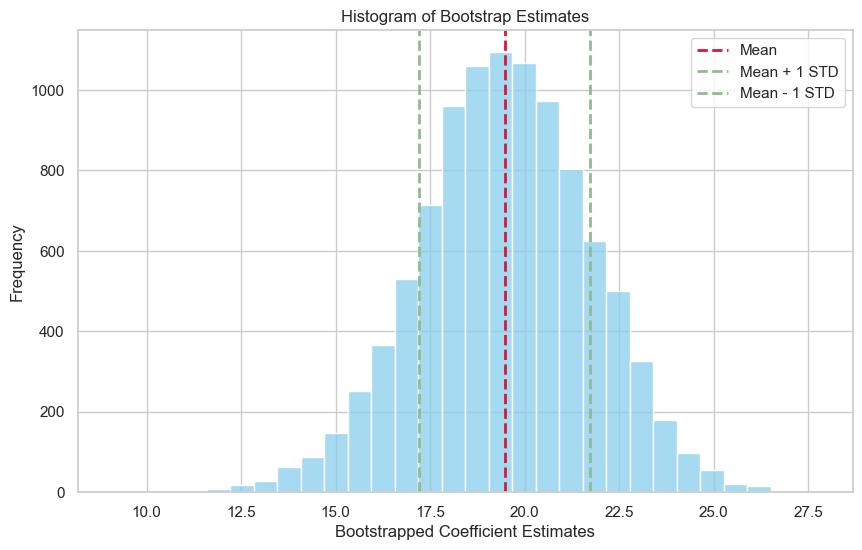

In [116]:
# Convert the numpy array to a pandas Series for easy plotting
bootstrap_series = pd.Series(bootstrap_estimates)

# Settings style
sns.set(style="whitegrid", palette="pastel")

# Create a histogram of the bootstrap estimates
plt.figure(figsize=(10, 6))
sns.histplot(
    bootstrap_series,
    bins=30,
    color="skyblue",
    alpha=0.75,
)

# Add lines for mean and standard deviation
plt.axvline(
    x=mean_estimate, color="crimson", linestyle="dashed", linewidth=2, label="Mean"
)
plt.axvline(
    x=mean_estimate + std_estimate,
    color="darkseagreen",
    linestyle="dashed",
    linewidth=2,
    label="Mean + 1 STD",
)
plt.axvline(
    x=mean_estimate - std_estimate,
    color="darkseagreen",
    linestyle="dashed",
    linewidth=2,
    label="Mean - 1 STD",
)

# Add title and labels
plt.title("Histogram of Bootstrap Estimates")
plt.xlabel("Bootstrapped Coefficient Estimates")
plt.ylabel("Frequency")
plt.legend()

# Show the plot
plt.show()

>- Bootstrapped Mean: The mean of the bootstrapped estimates is 19.4724.
>- Original Regression Coefficient: The coefficient from the original regression for Promotion is 19.4720.
>- Bootstrapped Standard Deviation: This value, 2.2622, represents the variability of the bootstrapped estimates around the mean. It indicates how spread out the bootstrapped estimates are.
>- Original Regression Standard Error: The standard error from the regression is 2.353, which measures the estimated standard deviation of the sampling distribution of the estimated coefficient.
>- The estimates of the coefficients are normally distributed based on the histogram.
>- The average value of these bootstrapped estimates is very close to the coefficient estimate from my regression.
>- The standard deviation of these bootstrapped estimates is very close to the standard error from my regression.

### Exercise 7

While there is a way to get p-values from bootstrapping, it actually requires a different kind of bootstrapping we don't want/need to get into here. 

But what we *can* ask is "if we did this experiment again, what is the likelihood that we'd get an estimate of the effect of `Promotion` that is 0 or less?" We do this by looking to see if 0 is within the 95% confidence interval of our estimate. 

This we can compute by sorting our estimates and looking at the bottom 2.5% (since confidence intervals are two-tailed, the 95% confidence interval excludes 2.5% of the probability mass on both sides). If that cutoff is above 0, we can say that 0 is outside the 95% confidence interval of our estimate.

What is the lower 2.5% cutoff?

In [117]:
# Calculate the 2.5th percentile of the bootstrap estimates
lower_2_5_percentile = np.percentile(bootstrap_estimates, 2.5)

print(
    f"The lower 2.5% cutoff of the bootstrap estimates is: {lower_2_5_percentile:.4f}"
)

The lower 2.5% cutoff of the bootstrap estimates is: 14.8880


> The lower 2.5% cutoff of the bootstrap estimates is: 14.8880. The cutoff is above 0. Therefore, we can say that 0 is outside the 95% confidence interval of our estimate.

### Exercise 8

Given the answer you got to Exercise 5 (very similar mean and standard deviation to what you got from the analytically calculated standard errors), you may be wondering why we bothered bootstrapping. And you wouldn't be wrong — as it turns out, the errors in the vanilla linear regression we ran above are quite normally distributed, and as a result, the standard errors are also accurate. 

To illustrate, here's a Q-Q plot of the regression residuals. [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) plots the quantiles of data against quantiles of a perfect distribution (here a normal distribution). The closer the data is to the expected line, the closer the data is to being distributed according to the specified distribution.

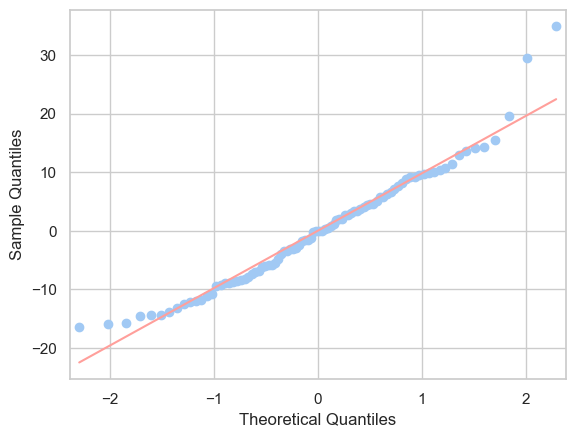

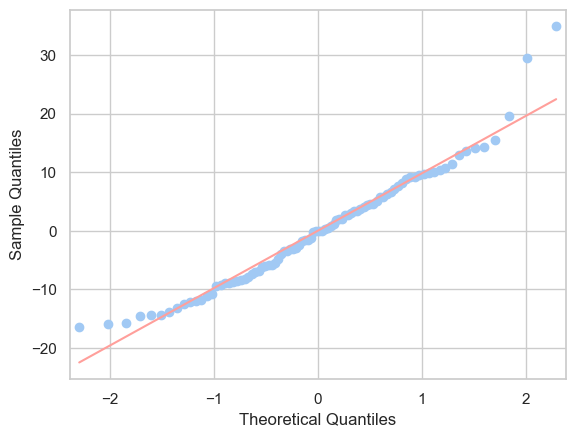

In [118]:
from statsmodels.graphics.gofplots import qqplot

qqplot(results_controls.resid, line="s")

And if we overlay data sampled from a normal distribution with the standard error given by the regression, we'd also get a distribution similar to that generated by our bootstrap:

In [ ]:
import seaborn.objects as so
from matplotlib import style
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# Get normal draws according to analytic regression
# standard errors
import numpy.random as npr

normal_draws = npr.normal(
    loc=fit_model.params["Promotion"], scale=fit_model.bse["Promotion"], size=100_000
)
normals = pd.DataFrame({"estimates": normal_draws, "source": "Normal Draws"})

# Combine with bootstrap estimates for ease of plotting
boot = pd.DataFrame({"estimates": estimates, "source": "Bootstrap"})
normal_and_boot = pd.concat([normals, boot])

(
    so.Plot(normal_and_boot, x="estimates", color="source")
    .add(so.Bars(), so.Hist(stat="density", common_bins=True, common_norm=True))
    .label(title="Normal Distribution Draws v. Bootstrap")
    .theme({**style.library["seaborn-v0_8-whitegrid"]})
)

![Image](bayesian.png)

But as well see very soon, in addition to being more flexible in terms of being able to accommodate data that is not normally distributed, we're going to make use of the array of sampled estimates bootstrapping generated in just a moment...

## What We Just Did

Let's talk a little about the different quantities we've calculated and how we can interpret them. 

### Rejecting the Null

The first thing we did was run a regular linear regression. That gave us a p-value, which is the probability that we would observe a difference between our treatment and control groups (i.e., a value of the coefficient on `Promotion`) at least as large as it was *if the null hypothesis that `Promotion` had no effect*. In the simplest approach to frequentist statistics, that's kinda where we start.

A more sophisticated Frequentist would:

1. make sure that the errors in that regression were pretty normally distributed and homoskedastic (since that's required for our regular linear regression coefficients and standard errors to be correct),
2. evaluate if the magnitude of the coefficient suggested it was *practically significant* (big enough that, if that were the true effect of the Promotion, it would be economically worthwhile to roll out the Promotion).

And perhaps an especially diligent Frequentist would go one step further and specify a different null hypothesis — namely, that the Promotion's effect was less than or equal to the practical significance threshold. Then they could get a p-value that would tell them "how likely it is we would see a coefficient at least this big if the true effect were [our threshold for practical significance] or less?" This we could do with a post-regression test (`result.t_test("Promotion - 15 = 0")` if `15` were the threshold for practical significance).

### Confidence Intervals

The second thing we did was to estimate the effect of `Promotion` using bootstrapping. This is also a Frequentist method, but one that doesn't require we make any assumptions about the distribution of the data (i.e., we don't have to assume the regression errors are normally distributed or homoskedastic). This approach doesn't lend itself to p-values (there is a way to do something similar to bootstrapping to get p-values), but it gives us confidence intervals we can use similarly. These tell us that if we did this experiment over and over, we think the likelihood we'd get a coefficient on `Promotion` equal to or less than zero is definitely less than 0.05, which is kinda analogous to (though not the same as) a p-value.

(Note that in this case, the errors from the regression *were* pretty close to being normally distributed and homoskedastic, which is why our bootstrapped distribution and the results from `statsmodels` looked very similar).

### What It Means For This To Be Frequentist

Everything we've done up until now, as I mentioned, we've done using traditional tools of Frequentist statistics, and we've been careful to interpret the results the way a Frequentist would: as an effort to characterize the uncertainty of our *estimate* of the true effect of Promotion.

That's because in Frequentist statistics, uncertainty comes from the fact that while there is a "True" effect of Promotion that gives rise to the data we observe, when we pull a finite set of N observations from this True Population, those N observations may not be perfectly representative of the population as a whole. Thus, we have uncertainty about whether the quantity we estimate is an accurate reflection of the "True" parameter value that underlies the data generating process that gives rise to all real data.

(You'll notice I'm using a lot of scare-quotes and weird capitalizations: that's because a key assumption of Frequentist statistics is that there *is* a True Effect, and a True Population. But... those are kinda made-up?)

So how else can we think about this?

## A (Slightly Heretical) Bayesian Perspective 

Bayesians see things differently. Rather than trying to estimate the value of the *One True Parameter*, Bayesians think that all knowledge of the world is probabilistic, and everything is uncertain to one degree or another. Bayesian inference, therefore, is all about trying to think carefully about this uncertainty, and crucially to understand how we should update our beliefs about the world when we get new information (e.g., data). 

A Bayesian analysis begins with the analyst articulating their current beliefs about the likely values of the parameter of interest (their "prior beliefs," often just referred to as "priors"). Then they use Bayes Rule to update those beliefs using the data being analyzed. This then generates a new, updated set of beliefs — called "posterior beliefs" or "posteriors" — which embody the analysts new, updated beliefs about the likely values of the parameter of interest.

As a result, they don't talk about the distribution of our *estimate* of the parameter, they talk about the probability distribution of the value of the parameter of interest itself.

And now the part that's a little heretical: one way to think about the "empirical distribution of *our estimate* of the effect of Promotion" is as our best guess for the likely distribution of our best guess for the value of the effect of Promotion.

Or, to be more precise (and to ensure Bayesian's don't get *too* mad at me), if our dataset it's too small, we can interpret that distribution as telling us:

**In a world where we know nothing about the promotion we're studying except the results of the statistical analysis, this is also our best guess for the probability distribution of the true effect of the Promotion.**

Now, to be clear, the caveat I included above — that this is only true **in a world where we know nothing about the likely effect of the promotion except the results of the statistical analysis** — is a big one. In the language of Bayesian statistics, saying we know nothing except the results of this analysis is analogous to saying we are starting with flat (also sometimes called "uninformative") priors.

And that's not a small thing — for example, the company that launched this campaign presumably at least *suspects* the promotion will improve sales. And based on its experience with past promotions, it is also probably pretty confident of the *approximate* magnitude of the biggest effect it may detect. For example, they probably know it won't 10x sales. And if we were doing a proper Bayesian analysis, we would take that kind of information into account by introducing what are called "weakly informative priors." (For a more detailed discussion with equations, hang on till the end of this exercise.)

But the distribution of our estimates of the effect of the promotion we got above is precisely the same distribution a Bayesian would get if they used purely Bayesian statistics and methods, provided they started with flat priors. Indeed, I'll demonstrate that at the end of this reading.

I bring this up for two reasons. 

First, I think there is merit in understanding this place where Frequentist and Bayesian statistics intersect. They are founded on different philosophies about the source of uncertainty, and in more sophisticated applications they diverge substantially. But they are also not entirely alien to one another.

But second, as I've mentioned before, I don't think it's the end of the world to sometimes use Frequentist statistical machinery and still reflect on it a little like a "poor man's Bayesian estimate." Yes, a fully Bayesian empirical analysis would likely generate somewhat different results, but unless you are using strong priors (asserting you have a significant sense of the likely effect of the promotion), the results you get will be relatively similar to what we are getting here. 

And if we decide that, as applied analysts, we're ok with thinking about that distribution as a probability of treatment effects we're likely to experience if we rolled out our experiment, we can do some really fun things.

## Outcome Simulation

Interpreting the result above as the probability distribution of the effect of our promotion is only interesting if we find a way to do something with it. So let's have some fun using Monte Carlos simulation techniques. 

Suppose we chose to deploy our promotion — what is likely to happen? We know that the most likely outcome is that the promotion will improve sales by our estimated ATE, but what are the range of possible outcomes? Even if we expect the promotion will *probably* make money, maybe what you're really worried about is loss-avoidance, in which case what you want to know is actually "what are the odds we *lose* money?" And how can we integrate information about the cost economics of the promotion into how we answer those questions? Let's find out!

### Exercise 9

Let's start with a simple example. Suppose that our promotion has a fixed cost per store per month. More specifically, suppose that it costs 17,000 dollars per store per month to run the promotion. What is the probability that, if the fast food company deployed the promotion, it would actually *lose* money?

To answer this question, simply figure out how to compute the company's per-store profit as a function of the ATE of the promotion. 

Then, for each estimate of the ATE we bootstrapped, calculate the profit if that estimate turned out to be the true ATE. 

Then calculate the share of bootstrapped "worlds" in which the per-store profits from the promotion were negative.

In [120]:
# Given costs and previously bootstrapped estimates
cost_per_store_per_month = 17000

# Calculate profits for each bootstrapped estimate
profits = (bootstrap_estimates * 1000) - cost_per_store_per_month

# Determine the proportion of negative profits
negative_profits = np.sum(profits < 0)
total_estimates = len(profits)
probability_of_loss = negative_profits / total_estimates

print(
    f"Probability of losing money by deploying the promotion: {probability_of_loss*100:.2f}%"
)

Probability of losing money by deploying the promotion: 13.31%


### You Did It!

Congratulations! You just did your first "scenario modelling!" And now you can probably see one of the reasons I chose to bootstrap our standard errors — it naturally generated this array of simulated draws of the Average Treatment Effect we can use for modelling!

That isn't to say bootstrapping is strictly necessary to do this type of analysis — because our data was relatively normally distributed, we could have done our scenario planning by using the `numpy.random.normal()` function to simulate draws from the normal distribution implied by our normal `statsmodels` results. But why add that step when?

### Exercise 10

OK, that wasn't a particularly complicated scenario. Let's suppose, instead, that the promotion costs $17,000 more per store per month, *and* 50 dollars per 1,000 in sales.

Now what's the probability you make LESS money with the promotion than without?

In [121]:
# Additional costs
additional_cost_per_thousand = 50

# Calculate profits considering both fixed and variable costs
profits = (
    bootstrap_estimates * (1000 - additional_cost_per_thousand)
) - cost_per_store_per_month

# Determine the proportion of negative profits
negative_profits = np.sum(profits < 0)
total_estimates = len(profits)
probability_of_loss = negative_profits / total_estimates

print(
    f"Probability of making less money with the promotion than without: {probability_of_loss*100:.2f}%"
)

Probability of making less money with the promotion than without: 23.37%


### Exercise 11

Now suppose that the firm that ran the Promotion is so confident in their promotional strategy that they approach you with an unusual pricing model. *They* think that the promotion will drive so much more sales than 18,000 per store that they say:

- You don't have to pay them *anything* for the first $18,000 increase in sales per store.
- Beyond those first 18,000 units sold:
  - For every 1,000 in sales beyond 18,000, what you pay us will increase *non-linearly* — namel, you'll have to pay 10 dollars per $1,000^{1.02}$ in increased sales.

What are the odds you'll lose money under this deal?

NOTE: Because we're using exponents, make sure to convert your units from "sales in 1,000s" to total sales by multiplying by 1,000. 

In [139]:
# Constants for the new pricing model
threshold_sales_increase = 18000
non_linear_cost_per_thousand = 10

# Calculate profits considering the new pricing model
profits = []
for ate in bootstrap_estimates:
    sales_increase = ate * 1000
    if sales_increase <= threshold_sales_increase:
        cost = 0
    else:
        value = (sales_increase - threshold_sales_increase) / 1000
        cost = non_linear_cost_per_thousand * value**1.02
    profit = sales_increase - cost
    profits.append(profit)

# Determine the proportion of negative profits
negative_profits = np.sum(np.array(profits) < 0)
total_estimates = len(profits)
probability_of_loss = negative_profits / total_estimates

print(
    f"Probability of losing money by deploying the promotion: {probability_of_loss*100:.2f}%"
)

Probability of losing money by deploying the promotion: 0.00%


### Exercise 12

Can you show your boss the full probability distribution of potential outcomes? Use 100 bins to ensure you get good granularity in the tails.

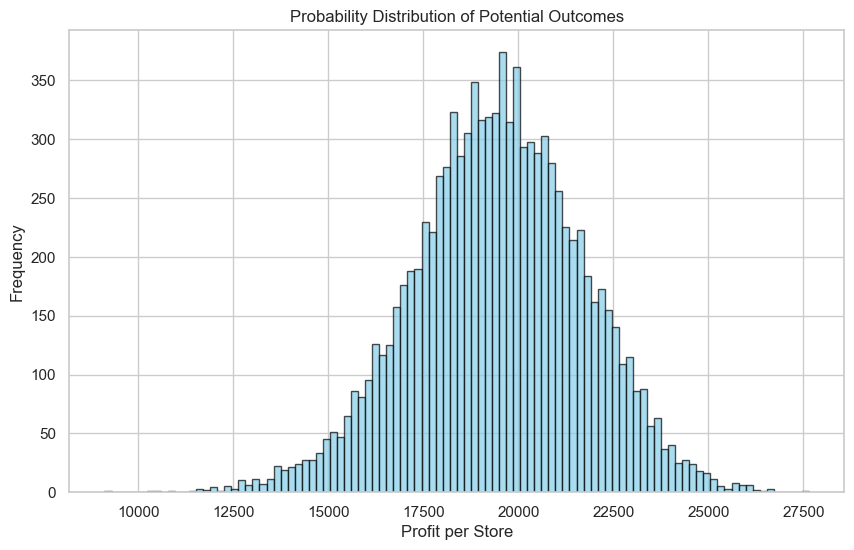

In [140]:
# Plot histogram of profits
plt.figure(figsize=(10, 6))
plt.hist(profits, bins=100, color="skyblue", edgecolor="black", alpha=0.7)
plt.title("Probability Distribution of Potential Outcomes")
plt.xlabel("Profit per Store")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Exercise 13

Fine, your boss is boring; she just wants to know the Expected Monetary Value of the promotion (recall the Expected Monetary Value of a decision under uncertainty is just $\sum_{i \in I} p_i v_i$ where $p_i$ is the probability of outcome $i$ and $v_i$ is the monetary value of outcome $i$). What would that be?

In [146]:
# Calculate probabilities based on the frequency of each profit outcome
probabilities = np.ones_like(profits) / len(profits)
# Calculate EMV by summing profits weighted by their respective probabilities
EMV = np.sum(np.array(profits) * np.array(probabilities))

print(f"Expected Monetary Value (EMV) of the promotion: ${EMV:.2f}")

Expected Monetary Value (EMV) of the promotion: $19453.71


## The Math

As I promised above, let's take a moment to review why we can think of this distribution as being equal to the probability distribution of our true ATE *if and only if* we are willing to assume we know nothing other than the results of this study. 

### Bayes Rule and Frequentist Statistics

As discussed previously, one of the challenges with the standard, Frequentist approach to A/B testing is that the statistics we get from these analyses (like p-values) rarely correspond to the substantive quantities we care about most.

In statistical notation, our estimate of the distribution of our estimate of the Average Treatment Effect can be written: $P(X|ATE)$ where $X$ is the data generated by our A/B test conditional on the $ATE$.

We sometimes fool ourselves into thinking that this quantity corresponds precisely to what we care about: the probability distribution of the true ATE given our estimate $P(ATE|X)$.

But as you can see, $P(X|ATE) \neq P(ATE|X)$. 

Thankfully, though, Bayes Rule does provide us with a way of determining how these quantities relate to each other. Bayes rule is often written as:

$$P(A | B) = \frac{P(A \cap B)}{P(B)}$$

We can rewrite $P(A \cap B)$ as $P(B | A) * P(A)$, let $A$ be $ATE$ and $B$ be our data $X$ to help us understand our problem better:

$$P(ATE | X) = \frac{P(X|ATE) * P(ATE)}{P(X)}$$

Here, we can see that quantity we are interested in (the probability distribution of $ATE$) on the left-hand side of the equation. We can also see that the first term on the right-hand side of the equation ($P(X|ATE)$) is the distribution we got from bootstrapping (or regular regression packages, conditional on some distributional assumptions). This leaves us with only two terms we need to understand: $P(ATE)$ and $P(X)$.

We call $P(ATE)$ our unconditional *prior* belief about $ATE$ — unconditional because we aren't conditioning on $X$ (the results of our analysis). This, in other words, what values of $ATE$ were plausible before your analysis began.

And $P(X)$? This term is actually kinda annoying and not that interesting, so we generally ignore it. Because we know that the left-hand side of our equation is a probability distribution, we know that the right-hand side has to integrate out to 1 (with respect to all possible values of $A$, which in this case is just whether the conditional probability distribution of $ATE$). So rather than trying to compute $P(X)$ directly, we usually figure out what it *must be* indirectly by figuring out what normalization gives us a valid probability distribution. 

As a result, we often just say that the left-hand side of the equation is *proportional* to the right-hand side, and write this using the $\propto$ symbol:

$$P(ATE | X) \propto P(X|ATE) * P(ATE )$$



### OK, why do I care?

OK, that was a lot of math. Why do I care about all this?

Two reasons:

### Reason 1: It is *critically* important that you understand what p-values and other Frequentist statistics are, and what they are not. 

P-values, as we discussed previously, are the probability of observing our data given the null hypothesis is true — i.e, $P(X|Null)$. It is *not* the probability that the null is true given the data ($P(Null|X)$).

If you get a p-value of 0.05 from an AB test showing that *increasing* latency increases user retention on a website, you should not assume that "Oh, well this only had a 5% probability of happening by chance! Latency must be increasing retention!" Rather, you should say "um, I have a pretty strong sense (a prior, $P(Null)$) that increasing latency does *not* increase retention. So I'm gonna be much more skeptical of that result than an AB test that shows a *decrease* in latency increases user retention with a p-value of 0.05.

### Reason 2: There *is* a special case where $P(ATE| X) = P(X| ATE)$

Suppose you know *nothing* about the treatment you seek to test. All possible outcomes, in your mind, are *equally* likely. This is the case of what is called a flat prior (also sometimes called an *uninformative prior*), and it essentially means $P(ATE)$ is a constant for all possible outcomes.

If $P(ATE)$ is a constant, then $P(ATE| X) \propto P(X| ATE) * c$ for some constant $c$. This implies $P(ATE| X) \propto P(X| ATE)$ (since constants drop out when doing proportionate comparisons). 

Now, I want to emphasize that assuming that all outcomes of $P(ATE)$ are equally likely is a *very* weird thing to assume. After all, you're doing an A/B test because you have some suspicion that your treatment will have an effect, right?

But I think it's helpful to consider this case as a way of understanding the relationship between Frequentist statistics like p-values and the quantities we often actually care about (like the probability that the Null hypothesis of no effect is true): namely, if we are willing to assume that the world started with the study we are conducting and ends with the study we are conducting, and that we know nothing except what is in our dataset, then these two *substantively and theoretically distinct* quantities will be the same.


### Reason 3: The Bernstein-von Mises Theorem

My reasoning 2 above is a *liiiiitle* hand-wavy. I think it's entirely appropriate for applied use, and it's a common perspective among many of my peers. However, it isn't *quite* precise enough for a pure statistician. What *is* precise enough, however, is the [Bernstein-von Mises Theory](https://en.wikipedia.org/wiki/Bernstein%E2%80%93von_Mises_theorem) which formalizes that logic for situations where your datasets get large (i.e. it's an asymptotic proof). I'm not gonna try and go into, but I do want to link to it in case it interests you.

## Doing It Like A Bayesian

And now, finally, I feel obligated to show you how you can do this using fully Bayesian machinery so we can compare results and you can see I'm not hiding anything under my hat. 

I'm doing this will a little hesitancy because, just as showing someone how to run a regression without explaining the assumptions that underlie it is a little like handing them a loaded gun, so too is showing you how to fit a Bayesian model without teaching you how Bayesian stats work in detail feels a little dangerous. But as the goal here is to give you a *sense* of how these things work, here we go.

If you want to follow along, we'll be using the [bambi package](https://bambinos.github.io/bambi/notebooks/getting_started.html), which provides an easy API for doing linear modelling using the library PyMC as a backend. To use it, install `bambi` and `arviz`. Note that Bayesian analysis comes with some pretty heavy duty computational libraries, so you may run into problems if you don't install these packages in a new, clean environment.

Also note that `bambi` *looks* like it uses formulas the way that `statsmodels` do, but the library doing it isn't patsy, so you'll find you have to make a few changes.

In [ ]:
import bambi as bmb
import arviz as az

# Prep vars since formula doesn't work the same way
sales["MarketID"] = pd.Categorical(sales["MarketID"])
sales["log_AgeOfStore"] = np.log(sales["AgeOfStore"])
sales["MarketID"].dtype

# Fit a linear model
# with flat / uninformative priors.
model = bmb.Model(
    "total_sales ~ Promotion + log_AgeOfStore + MarketID",
    sales,
    priors={"common": bmb.Prior("Flat")},
)
results = model.fit(draws=10_000, chains=4)
az.summary(results)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [total_sales_sigma, Intercept, Promotion, log_AgeOfStore, MarketID]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 8 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,143.366,5.028,134.008,152.991,0.038,0.027,17146.0,23705.0,1.0
MarketID[2],103.607,5.933,92.444,114.985,0.040,0.028,22270.0,27075.0,1.0
MarketID[3],197.929,4.781,189.058,207.141,0.038,0.027,16222.0,24485.0,1.0
MarketID[4],73.436,6.129,61.705,84.858,0.040,0.028,23936.0,29035.0,1.0
MarketID[5],62.162,5.627,51.337,72.605,0.039,0.028,20781.0,26505.0,1.0
MarketID[6],3.976,5.228,-5.847,13.878,0.038,0.027,18780.0,26073.0,1.0
MarketID[7],37.410,5.027,27.855,46.844,0.038,0.027,17975.0,26799.0,1.0
MarketID[8],50.425,5.065,40.914,60.084,0.037,0.026,18380.0,26934.0,1.0
MarketID[9],66.364,5.425,56.299,76.761,0.039,0.027,19555.0,26818.0,1.0
MarketID[10],79.693,5.256,69.880,89.649,0.039,0.027,18565.0,26965.0,1.0


Now let's compare the results from our bootstrap approach above to what we get from the Bayesian model. 

In [ ]:
# Get sampled observations of the value of Promotion from Bambi.
bambi_draws = results.posterior["Promotion"].loc[0, :].values

In [ ]:
# Now I'm going to sample from the posterior of the model
pymc = pd.DataFrame(
    {"estimated_ATE": bambi_draws, "source": "posterior draws with flat priors"}
)
bootstrap = pd.DataFrame({"estimated_ATE": estimates, "source": "bootstrap estimates"})
all_draws = pd.concat([bootstrap, pymc])

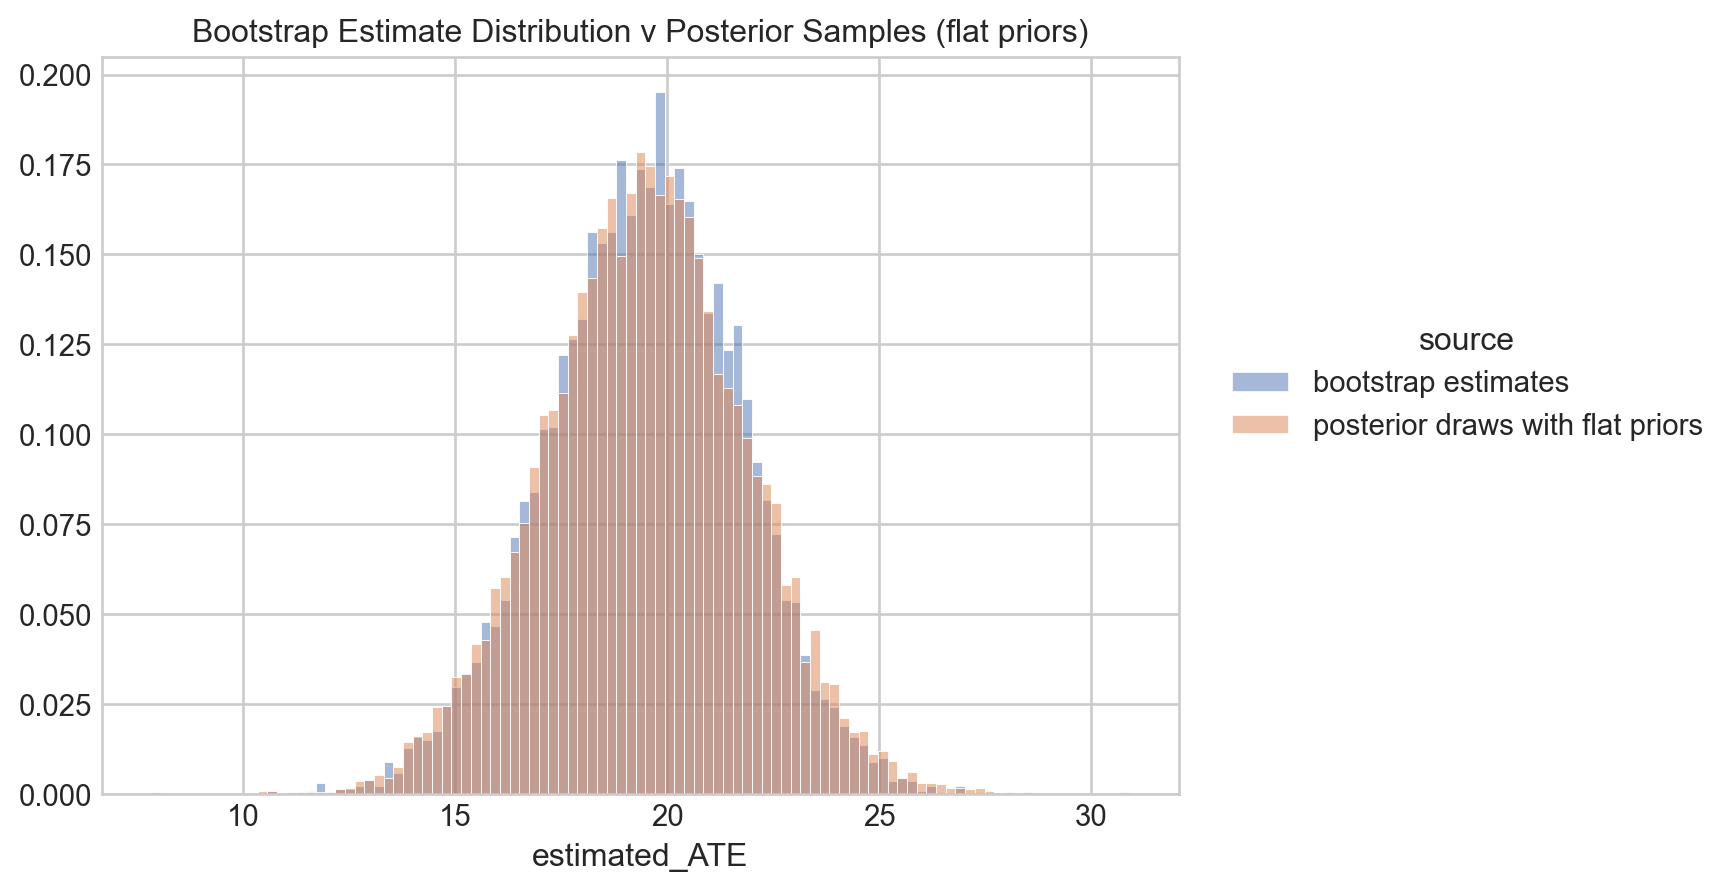

In [ ]:
import seaborn.objects as so
from matplotlib import style
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)


(
    so.Plot(all_draws, x="estimated_ATE", color="source")
    .add(
        so.Bars(alpha=0.5), so.Hist(stat="density", common_bins=True, common_norm=True)
    )
    .label(title="Bootstrap Estimate Distribution v Posterior Samples (flat priors)")
    .theme({**style.library["seaborn-v0_8-whitegrid"]})
)

See? Nearly the same!

Now again, a true Bayesian would never use Flat priors, and if I let Bambi pick what are called "weakly informative" priors (basically priors that way "I really don't think there are really extreme values"), you'll see we get something very similar, but with slightly more probability mass in the middle of the distribution:

In [ ]:
# If priors are not specified, weakly informative choices are made
# https://mc-stan.org/rstanarm/articles/priors.html#default-weakly-informative-prior-distributions-1

weakly_informative_prior_model = bmb.Model(
    "total_sales ~ Promotion + log_AgeOfStore + MarketID",
    sales,
)
weakly_informative_prior_results = weakly_informative_prior_model.fit(
    draws=10_000, chains=4
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [total_sales_sigma, Intercept, Promotion, log_AgeOfStore, MarketID]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 8 seconds.


In [ ]:
weakly_informative_bambi_draws = (
    weakly_informative_prior_results.posterior["Promotion"].loc[0, :].values
)

weakly_informative_draws = pd.DataFrame(
    {
        "estimated_ATE": weakly_informative_bambi_draws,
        "source": "Posterior Samples with Weakly Informative Estimates",
    }
)
all_draws = pd.concat([all_draws, weakly_informative_draws])

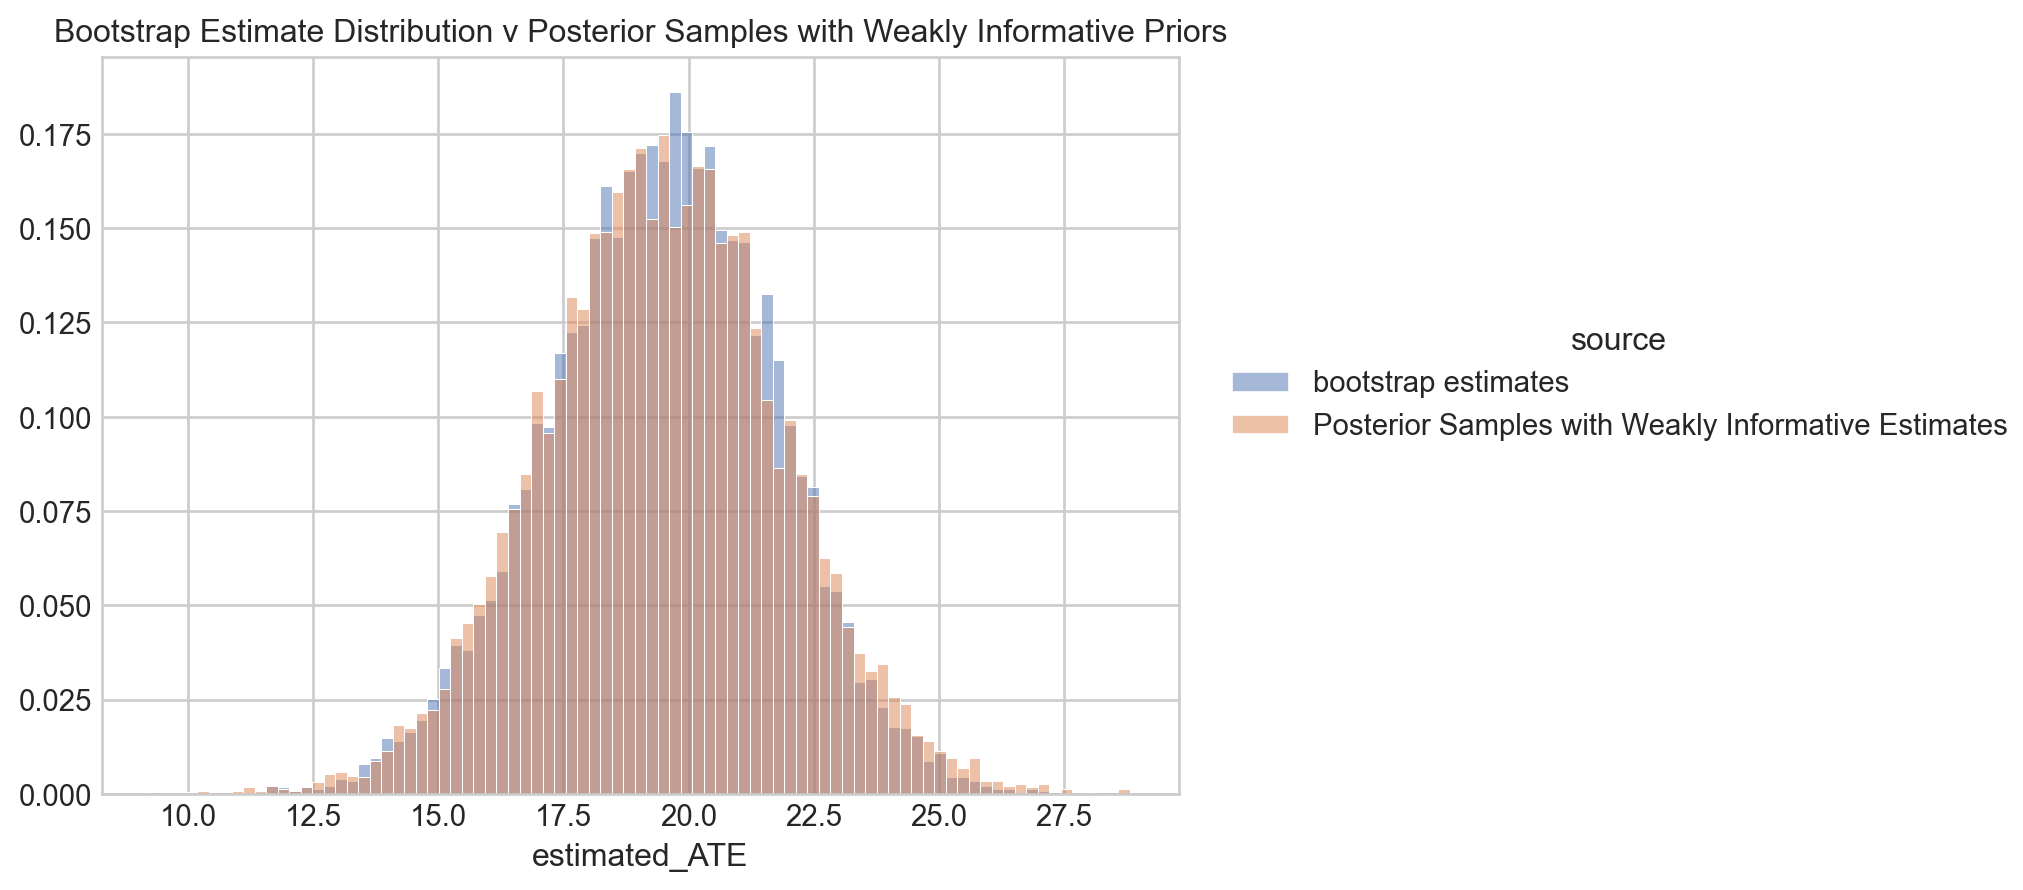

In [ ]:
(
    so.Plot(
        all_draws[all_draws.source != "posterior draws with flat priors"],
        x="estimated_ATE",
        color="source",
    )
    .add(
        so.Bars(alpha=0.5), so.Hist(stat="density", common_bins=True, common_norm=True)
    )
    .label(
        title="Bootstrap Estimate Distribution v Posterior Samples with Weakly Informative Priors"
    )
    .theme({**style.library["seaborn-v0_8-whitegrid"]})
)

## Still Reading?

Then you should take a class on applied Bayesian statistics. It's very cool, and honestly just makes way, *way* more sense than Frequentist stats. And now that computers are superfast, we can do Bayesian statistics *far* more easily than we could just a decade ago. 